# Y'a-t-il du vent pour mon foil? Récupération de données en temps réel

par Aurélie RAOUL

## Contexte du projet

Après avoir vu les images de l’America’s cup dans la baie d’Auckland, Cléante de Nantes a décidé de se mettre au catamaran avec foil.

Avant d’investir dans son engin high tech, elle a décidé de faire une petite application pour sa montre connectée qui donne en temps réel les dernières mesures sur 3 stations locales disposant d’un anémomètre. Elle souhaite savoir où se diriger pour trouver le vent nécessaire à ses futures activités.

Malheureusement sa montre dispose d’un stockage particulièrement réduit, donc la base de données locale devra être mise à jour régulièrement tout en s’assurant de ne pas dépasser un volume de stockage correspondant aux 10 derniers enregistrements. Enfin, un tantinet paranoïaque, elle souhaite absolument avoir la dernière sauvegarde qui devra être mise à jour régulièrement (une fois tous les 5 enregistrements).

Pourrez-vous aider Cléante à réaliser son projet en moins de 48h chrono?

Contrainte: usage de SQLite sur la montre

Les données pourront être récupérées auprès d’anémomètres connectés: les “pioupiou”s https://www.openwindmap.org/PP308

Ceux-ci disposent d’une API qui peut être interrogée: http://developers.pioupiou.fr/api/live/

Modalités pédagogiques : Groupes de 1 oe 2 apprenants
Critères de performance : Efficience du code
Livrables : La base de données, le code d'actualisation de la base en continu et sa méthode de sauvegarde.

In [1]:
from IPython.display import Image
from os import getcwd
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\wokspace-simplon3\\simplon\\projets\\projet_sql\\'

# 1. Données du web service

## 1.1. Contenu de la réponse de l'API
```json
{
  "doc": "http://developers.pioupiou.fr/api/live/",
  "license": "http://developers.pioupiou.fr/data-licensing",
  "attribution": "(c) contributors of the Pioupiou wind network <http://pioupiou.fr>",
  "data": [
    {
      "id": 1,
      "meta": {
        "name": "Pioupiou 1",
        "description": null,
        "picture": null,
        "date": null,
        "rating": {
          "upvotes": 0,
          "downvotes": 0
        }
      },
      "location": {
        "latitude": 0,
        "longitude": 0,
        "date": null,
        "success": false
      },
      "measurements": {
        "date": "2015-08-18T08:19:46.000Z",
        "pressure": null,
        "wind_heading": 157.5,
        "wind_speed_avg": 2,
        "wind_speed_max": 4,
        "wind_speed_min": 0
      },
      "status": {
        "date": "2015-08-18T08:19:46.000Z",
        "snr": 23.24,
        "state": "on"
      }
    },
    {
      "id": 27,
      "meta": {
        "name": "Pioupiou 27",
        "description": null,
        "picture": null,
        "date": null,
        "rating": {
          "upvotes": 0,
          "downvotes": 0
        }
      },
      "location": {
        "latitude": 44.907284,
        "longitude": 5.677965,
        "date": "2015-08-15T13:48:38.000Z",
        "success": true
      },
      "measurements": {
        "date": "2015-08-18T08:18:26.000Z",
        "pressure": null,
        "wind_heading": 45,
        "wind_speed_avg": 15,
        "wind_speed_max": 17.5,
        "wind_speed_min": 10.5
      },
      "status": {
        "date": "2015-08-18T08:18:26.000Z",
        "snr": 12.01,
        "state": "on"
      }
    },
    {...more stations...},
    {...more stations...}
  ]
}
```

## 1.2. Description des données

|Name                         |live |live-with-meta|Description                                                                                                                     |Unit         |
|-----------------------------|-----|--------------|--------------------------------------------------------------------------------------------------------------------------------|-------------|
|id                           |x    |x             |Numeric ID of the station                                                                                                       |             |
|meta.name                    |x    |x             |Name of the station                                                                                                             |             |
|meta.description             |     |x             |Description of the station, or null                                                                                             |             |
|meta.picture                 |     |x             |URL of station's picture, or null                                                                                               |             |
|meta.date                    |     |x             |Date of last metadata update, or null                                                                                           |ISO 8601, UTC|
|meta.rating.upvotes          |     |x             |Station rating : Positive votes count                                                                                           |             |
|meta.rating.downvotes        |     |x             |Station rating : Negative votes count                                                                                           |             |
|location.latitude            |x    |x             |Last known Latitude of the station, or null                                                                                     |WGS84        |
|location.longitude           |x    |x             |Last known Longitude of the station, or null                                                                                    |WGS84        |
|location.date                |x    |x             |Date of last location update (succeed or failed), or null                                                                       |ISO 8601, UTC|
|location.success             |x    |x             |Is the last known position still valid ? true or false                                                                          |             |
|measurements.date            |x    |x             |Date of last measurements, or null                                                                                              |ISO 8601, UTC|
|measurements.pressure        |x    |x             |null (deprecated)                                                                                                               |             |   
|measurements.wind_heading    |x    |x             |Wind heading, or null (0° means the wind is blowing from North to Sud)                                                          |degrees      |   
|measurements.wind_speed_avg  |x    |x             |Wind speed average, or null (over the last 4 minutes before measurements.date, divide by 1.852 for converting to knots)         |km/h         | 
|measurements.wind_speed_min  |x    |x             |Minimum wind speed, or null (over the last 4 minutes before measurements.date, divide by 1.852 for converting to knots)         |km/h         | 
|measurements.wind_speed_max  |x    |x             |Maximum wind speed, or null (over the last 4 minutes before measurements.date, divide by 1.852 for converting to knots)         |km/h         | 
|status.date                  |x    |x             |Date of the last contact with the station, or null                                                                              |ISO 8601, UTC|
|status.snr                   |x    |x             |Signal-to-Noise ratio = radio link quality, or null (<10 : bad, >20: very good)                                                 |dB           | 
|status.state                 |x    |x             |"Station power state, ""on"", ""off"" or null. ""off"" means that the station have been shutdown by pressing it's power switch."|             |

## 1.3. Codes d'erreur

An ```HTTP/1.1 200 OK``` header is sent on successful request. HTTP status code other than ```200``` means that an error has occured.

In most cases the application will return a JSON object, including details about the error.

```
$ curl -i "http://api.pioupiou.fr/v1/live/999999"
```

```json
HTTP/1.1 404 Not Found

{
  "error_code": "station_not_found",
  "error_message": "unable to find station with this {station_id}"
}
```

|error_code       |HTTP code |Description                                 |
|-----------------|----------|--------------------------------------------|
|station_not_found| 	404 	 |The requested station is not in the database|
|missing_argument | 	400 	 |The station ID is missing or invalid        |

## 1.4. Schéma des données

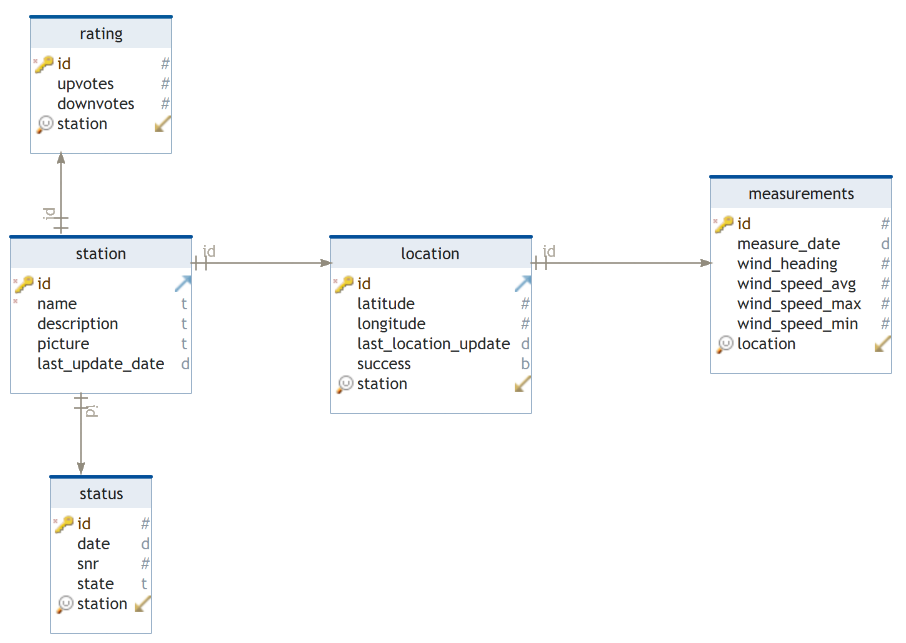

In [4]:
Image(filename = file_path + "schema_pioupiou_full.png")

# 2. Sélection des données

Pour notre projet, toutes les données ne sont pas utiles, de plus il faut tenir compte de l'espace de stockage réduit et la notion de temps réel.
Les données sélectionnées sont donc :

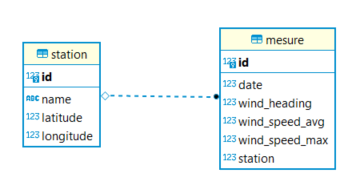

In [38]:
Image(filename = file_path + "schema_pioupiou_selected.png")

# X. CODE

## X.1. SQL Script

```sql
DROP TABLE IF EXISTS mesure;
DROP TABLE IF EXISTS station;

CREATE TABLE station (
	id INTEGER PRIMARY KEY AUTOINCREMENT,
	station_name TEXT NOT NULL,
	latitude REAL,
	longitude REAL
);


CREATE TABLE mesure (
	id INTEGER PRIMARY KEY AUTOINCREMENT,
	mesure_date TEXT NOT NULL,
	wind_heading REAL,
	wind_speed_avg REAL,
	wind_speed_max REAL,
	station INTEGER,
	FOREIGN KEY(station) references station(id)
);

```

In [39]:
import requests
from datetime import datetime
import sqlite3

In [41]:
stations_proche_nantes = {
    "Groix": 298,
    "Brétignolles sur mer": 113,
    "L'île-d'Olonne":308,
    "La Rochelle":565
}

stations_22 = {
    "Pordic": 194,
    "Plérin": 116,
    "Champeaux":334
}

PP_URL_API_LIVE = "http://api.pioupiou.fr/v1/live/"

BDD_NAME = 'my_piou_piou_raoul_aurelie.db'

## X. Lecture du format JSON

```json
{ 'id': 194, 
  'meta': 
    {'name': "Balise des Goélands d'Armor de la pointe de Pordic"}, 
  'location': {'latitude': 48.582274, 'longitude': -2.780045, 'date': '2022-01-16T08:49:07.000Z', 'success': True}, 
  'measurements': {'date': '2022-01-17T09:25:49.000Z', 'pressure': None, 'wind_heading': 270, 'wind_speed_avg': 0.25, 'wind_speed_max': 2, 'wind_speed_min': 0}, 
  'status': {'date': '2022-01-17T09:25:49.000Z', 'snr': 0, 'state': 'on'}
}
```

In [45]:
# TODO, ajouter les données en BDD
def process_json(data):
    id = data['id']
    name = data['meta']['name']
    measures = data['measurements']
    measures_date_str1 = measures['date']
    wind_heading = measures['wind_heading']
    wind_speed_avg = measures['wind_speed_avg']
    wind_speed_min = measures['wind_speed_min']
    # convertion en date
    measures_date_str = datetime.fromisoformat(measures_date_str1[:-1])
    # "2022-01-17T09:45:47.000Z"  ==> YYYY-MM-DDTHH:MM:SS.mmmmmm
    measures_date = measures_date_str.strftime('%Y-%m-%d %H:%M:%S')
    
    print(f"{id} : {measures_date} - {wind_heading}, {wind_speed_avg}, {wind_speed_min} => {name}")

In [46]:
# Récupération des données de l'API
for pp_id in stations_22.values():
    # appel de l'API avec l'ID de la station
    resp = requests.get(url=PP_URL_API_LIVE+str(pp_id))
    data = resp.json() # Check the JSON Response Content documentation below
    # TODO : vérifier qu'il n'y a pas d'erreur (retour en erreur)
    # Traitement de la réponse JSON
    process_json(data['data'])

    print("----------------------------------")


194 : 2022-01-17 15:15:47 - 135, 1.5, 0 => Balise des Goélands d'Armor de la pointe de Pordic
----------------------------------
116 : 2022-01-17 15:08:21 - 67.5, 1, 0 => Balise des Goélands d'Armor de Martin Plage
----------------------------------
334 : 2022-01-17 15:11:36 - 225, 2.25, 0 => Pioupiou 334
----------------------------------


In [42]:
def bdd_connexion_query(bdd_name, query, verbose=False):
    try:
        conn = sqlite3.connect(bdd_name)
        cur = conn.cursor()
        if verbose > 1:
            print("Base de données crée et correctement connectée à SQLite")
        cur.execute(query)
        res = cur.fetchall()
        cur.close()
        conn.close()
        if verbose > 1:
            print("La connexion SQLite est fermée")
        return res
    except sqlite3.Error as error:
        print("Erreur lors de la connexion à SQLite", error)
        return None


def bdd_connexion_test(bdd_name, verbose=False):
    try:
        sql = "SELECT sqlite_version();"       
        res = bdd_connexion_query(bdd_name, sql, verbose)
        print("La version de SQLite est: ", res)
        return True
    except sqlite3.Error as error:
        print("Erreur lors de la connexion à SQLite", error)
        return False

In [43]:
bdd_connexion_test(BDD_NAME, 2)

Base de données crée et correctement connectée à SQLite
La connexion SQLite est fermée
La version de SQLite est:  [('3.35.5',)]


True

In [44]:
sql = "SELECT * FROM station"       
bdd_connexion_query(BDD_NAME, sql)

[]